<a href="https://colab.research.google.com/github/Phrmth/New/blob/master/Residual_network_(RESNETs)_from_scratch_on_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# import packages 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch import tensor
from torch import nn
import torch.nn.functional as F
import torch
from torch import optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset

In [0]:

if torch.cuda.is_available():
 device = torch.device("cuda")
else : device = torch.device("cpu")

# Hyper-parameters 
num_epochs = 20
batch_size = 100
learning_rate = 0.001

# Image preprocessing modules
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])

In [0]:
# Data
# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='../../data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../../data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [0]:
class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv(nf,nf)
        self.conv2 = conv(nf,nf)
        
    def forward(self, x): return x + self.conv2(self.conv1(x))

res_block = ResBlock

# Refactoring - Conv layer, BatchNorm and ReLU sequence 
def conv(ni,nf, stride = 1): return nn.Sequential(nn.Conv2d(ni, nf, kernel_size=3, stride=stride , padding=1), 
                                      nn.ReLU(),
                                      nn.BatchNorm2d(nf)
                                       
                                       )
def conv_and_res(ni,nf): return nn.Sequential(conv(ni, nf, stride = 2), res_block(nf))


model = nn.Sequential(
    conv_and_res(1, 8), #14
    conv_and_res(8, 16),  #7
    conv_and_res(16, 32),  # 4
    conv_and_res(32, 16), # 2
    conv(16, 10, stride = 2),    #1
    nn.Flatten()
)

In [87]:
model

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResBlock(
      (conv1): Sequential(
        (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv2): Sequential(
        (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (1): Sequential(
    (0): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResBlock(
      (conv1): Sequential(
     

In [0]:
from torchvision import models
from torchsummary import summary

summary(model, (1,28,28))

In [0]:
# Loss and optimizer
loss_fn = nn.CrossEntropyLoss().to(device)
opt = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=.01)

In [0]:
# Model fit - Train and validation scores per epoch !
train_loss = []
valid_loss = []
ep, learnrate , err , err_v = [],[],[],[]

def fit(epochs, model , train_loader, test_loader, opt, loss_func ):
  
  model.to(device)
  curr_lr = learning_rate
  for epoch in range(epochs):
    
    for i,(xb, yb) in enumerate(train_loader):
      # print(xb.shape)
      model.train()
      opt.zero_grad()
      xb,yb = xb.to(device),yb.to(device)

      pred = model(xb)
      loss = loss_func(pred,yb)
      loss.backward()
      opt.step()

    train_loss.append(loss)
      # with torch.no_grad():
      #   for p in model.parameters(): p-= p.grad * lr

    with torch.no_grad():
      for xv,yv in test_loader:
        
        xv,yv = xv.to(device),yv.to(device)
        pred = model(xv)
        loss_v = loss_func(pred,yv)

      valid_loss.append(loss_v)
    ep.append(epoch)
    learnrate.append(curr_lr)
    err.append(loss.item())
    err_v.append(loss_v.item())

        # Decay learning rate
    if (epoch+1) % 3 == 0:
      curr_lr /= 2
      update_lr(opt, curr_lr)

    
    if (epoch+1) % 5 == 0: 
      print(f"Epoch{epoch} : Train Loss {loss.item()} , Valid Loss {loss_v.item()}")
  
  return train_loss, valid_loss,ep,learnrate,err,err_v


In [102]:
# Training and Validation Loss 
%time train_loss, valid_loss,ep,learnrate,err,err_v = fit(10, model, train_loader, test_loader, opt, loss_fn)

Epoch4 : Train Loss 0.07510414719581604 , Valid Loss 0.05208158865571022
Epoch9 : Train Loss 0.09330324828624725 , Valid Loss 0.04985608160495758
CPU times: user 3min 20s, sys: 745 ms, total: 3min 21s
Wall time: 3min 21s


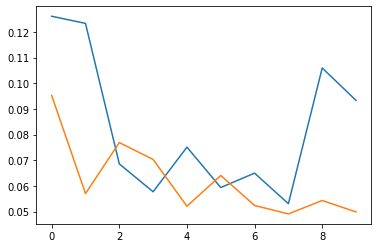

In [103]:
plt.plot(ep, err)
plt.plot(ep, err_v)


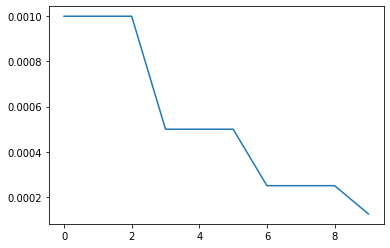

In [104]:
plt.plot(ep, learnrate)

In [0]:
# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [105]:
# Final testing on validation data of 10000 samples. 
with torch.no_grad():
  correct = 0
  total = 0
  model = model.to(device)
  # print(model)
  for xv,yv in test_loader:
    xv,yv = xv.to(device),yv.to(device)
    pred = model(xv)
    # print(pred)
    # _, predicted = torch.max(pred.data, 1)
    total += yv.size(0)
    # print("correct per batch",(torch.argmax(pred,dim = 1) == yv).sum())
    correct += (torch.argmax(pred,dim = 1) == yv).sum()
    # print(f"Accuracy per batch is {((torch.argmax(pred,dim = 1) == yv).sum().item())/yv.size(0)}")
  print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))


Accuracy of the network on the 10000 test images: 99 %
